In [2]:
import os 
import cv2
from skimage import morphology
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import regionprops
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

os.chdir('C:/Users/Akikawa/HuangLab/data_analysis/Archive-copy/')

c:\Users\Akikawa\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [22]:
def binary(gray, threshold_value = 29000, image_type='light'):
    # threshold using set values
    if gray.dtype == np.uint8:
        max_value = np.iinfo(gray.dtype).max
    elif gray.dtype == np.uint16:
        max_value = np.iinfo(gray.dtype).max
    else:
        raise ValueError(f"Unsupported data type: {gray.dtype}")

    # Apply thresholding using the cv2.THRESH_BINARY method
    _, binary_image = cv2.threshold(gray, threshold_value, max_value, cv2.THRESH_BINARY)
    if image_type == 'light':
        binary_image = max_value - binary_image
    
    return binary_image


def tophat(image, image_type, kernel_size, 
            blur_size=(15, 15), standard_variance=0):
    if image_type == 'light':
        topimage = np.iinfo(image.dtype).max - image
    else:
        topimage = image
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    tophat = cv2.morphologyEx(topimage, cv2.MORPH_TOPHAT, kernel)

    
    tophat_blur = cv2.GaussianBlur(tophat, blur_size, standard_variance)
    otsu_threshold, otsu_binary = cv2.threshold(tophat_blur, 0, np.iinfo(tophat_blur.dtype).max, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return otsu_binary


def segment_using_watershed(preprocessed_image, min_distance=15):
    # Compute the Euclidean distance from every binary pixel to the nearest zero pixel
    D = ndimage.distance_transform_edt(preprocessed_image)

    # Find peaks in the distance map
    local_max_coords = peak_local_max(D, min_distance=min_distance, labels=preprocessed_image)
    
    # Create a boolean array of the same shape as the input image
    local_max_image = np.zeros_like(D, dtype=bool)
    
    # Set the local maxima positions to True
    for coord in local_max_coords:
        local_max_image[coord[0], coord[1]] = True
    
    # Perform connected-component analysis on the local peaks and label them
    markers = ndimage.label(local_max_image)[0]
    
    # Perform watershed segmentation to separate touching cells
    labels = watershed(-D, markers, mask=preprocessed_image)
    
    return labels
    

def filter_by_size(labels, min_area=30, max_area=400):
    # Create an empty label image with the same shape as the input image
    filtered_labels = np.zeros_like(labels)
    
    # Filter regions based on area and circularity
    cell_count = 0
    for region in regionprops(labels):
        area = region.area

        if min_area <= area <= max_area:
            cell_count += 1
            filtered_labels[labels == region.label] = cell_count
    
    return cell_count, filtered_labels


def filter_by_circularity(labels, min_circularity=0.7):
    # Create an empty label image with the same shape as the input image
    filtered_labels = np.zeros_like(labels)
    
    # Filter regions based on area and circularity
    cell_count = 0
    for region in regionprops(labels):
        area = region.area
        circularity = 4 * np.pi * area / (region.perimeter ** 2)

        if circularity >= min_circularity:
            cell_count += 1
            filtered_labels[labels == region.label] = cell_count
    
    return cell_count, filtered_labels


def closing(labels, 
            dilate_iterations=1, dilate_kernel_size=(5, 5), dilate_kernel_type=cv2.MORPH_ELLIPSE,
            erode_iterations=1, erode_kernel_size=(5, 5), erode_kernel_type=cv2.MORPH_ELLIPSE):
    # Create an empty array to store the processed labels
    closing_labels = np.zeros_like(labels)
    dilate_labels = np.zeros_like(labels)

    # Get the unique labels in the labeled matrix
    unique_labels = np.unique(labels)

    # Define the kernel for dilation and erosion
    dilate_kernel=cv2.getStructuringElement(dilate_kernel_type, dilate_kernel_size)
    erode_kernel=cv2.getStructuringElement(erode_kernel_type, erode_kernel_size)

    # Loop through each unique label
    for label in unique_labels:
        if label == 0:  # Skip the background label
            continue

        # Create a binary mask for the current label
        mask = (labels == label).astype(np.uint8)

        # Perform dilation on the binary mask
        dilated_mask = cv2.dilate(mask, dilate_kernel, iterations=dilate_iterations)
        dilate_labels[dilated_mask == 1] = label

        # Perform erosion on the dilated mask
        eroded_mask = cv2.erode(dilated_mask, erode_kernel, iterations=erode_iterations)

        # Replace the original values in the processed labels with the updated values from the eroded mask
        closing_labels[eroded_mask == 1] = label

    return dilate_labels, closing_labels

def match_cells(microscopy_labels, fluorescent_labels, dis_thre=5):
    microscopy_regions = regionprops(microscopy_labels)
    fluorescent_regions = regionprops(fluorescent_labels)

    matched_cells = []
    not_matched_cells = []
    
    for fluo_region in fluorescent_regions:
        fluo_center = fluo_region.centroid
        match_flag = False

        for micro_region in microscopy_regions:
            micro_center = micro_region.centroid

            distance = np.sqrt((micro_center[0] - fluo_center[0])**2 + (micro_center[1] - fluo_center[1])**2)

            if distance < dis_thre:  # Adjust the threshold based on the expected maximum distance between cell centers
                matched_cells.append((micro_region, fluo_region))
                match_flag = True
                break
        if not match_flag:
            not_matched_cells.append(fluo_region)
        

    return matched_cells, not_matched_cells

def plot_mask(microscopy_image, 
              light_process, matched_cells,
              fluo_process, not_matched_cells,
              transparency=0.3):
    # Load the 16-bit grayscale TIFF image and the RGB mask image
    rgb_image = cv2.cvtColor(microscopy_image, cv2.COLOR_GRAY2BGR)

    matched_mask_image = np.zeros(rgb_image.shape, dtype=np.uint16)
    not_matched_mask_image = np.zeros(rgb_image.shape, dtype=np.uint16)

    # Draw the matched cells on the result image
    for micro_region, fluo_region in matched_cells:
        # Use the microscopy region's coordinates to create a mask for the cell
        cell_mask = (light_process == micro_region.label)

        # Set the color for the cell (e.g., red)
        match_cell_color = (0, 60000, 0)  # BGR format: (blue, green, red)

        # Draw the cell on the result image
        matched_mask_image[cell_mask] = match_cell_color

    for fluo_region in not_matched_cells:
        cell_mask = (fluo_process == fluo_region.label)

        # Set the color for the cell (e.g., red)
        not_match_cell_color = (0, 0, 60000)  # BGR format: (blue, green, red)

        # Draw the cell on the result image
        not_matched_mask_image[cell_mask] = not_match_cell_color

    # Blend the first mask with the RGB image
    result = cv2.addWeighted(rgb_image, 1-transparency, matched_mask_image, transparency, 0)

    # Blend the second mask with the result
    result = cv2.addWeighted(result, 1-transparency, not_matched_mask_image, transparency, 0)
    
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    normed_result = (result - result.min()) / (result.max() - result.min())

    return normed_result

In [5]:
# Preprocess and segment the light microscopy image
light_image = cv2.imread("./{}h/{}.TIF".format(3, 9), cv2.IMREAD_UNCHANGED)
light_binary = binary(light_image, threshold_value=33000)

In [142]:
# close
light_binary_close = closing(light_binary, 
            dilate_iterations=10, dilate_kernel_size=(3, 3), dilate_kernel_type=cv2.MORPH_ELLIPSE,
            erode_iterations=10, erode_kernel_size=(3, 3), erode_kernel_type=cv2.MORPH_ELLIPSE)

kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
light_binary_open = cv2.morphologyEx(light_binary_close, cv2.MORPH_OPEN, kernel_open)
plt.imshow(light_binary, cmap='nipy_spectral')

In [6]:
# display
cv2.imshow("Thresholded Blocks", light_binary)
cv2.waitKey()
cv2.destroyAllWindows()

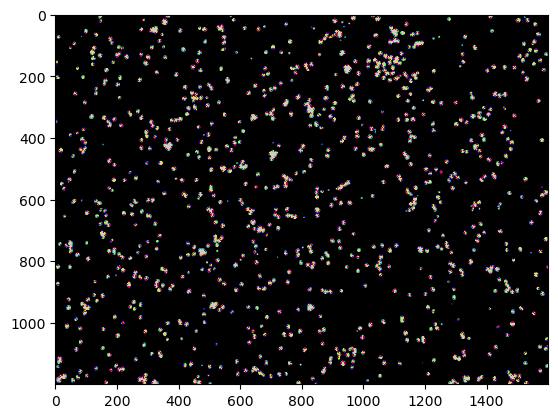

In [7]:
# tophat
tophat_image = tophat(light_image, image_type='light', kernel_size=(6, 6))

tophat_float = tophat_image.astype(float)
tophat_norm = cv2.normalize(tophat_float, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
plt.imshow(tophat_norm, cmap='nipy_spectral')

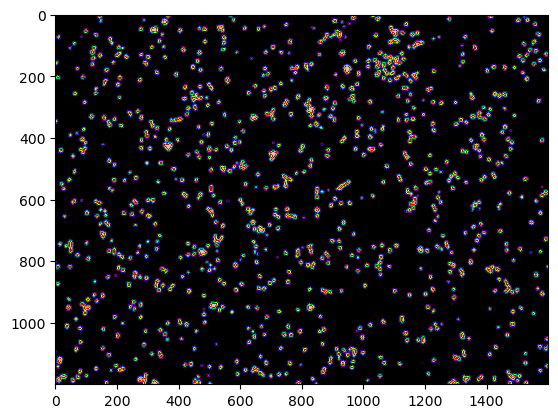

In [8]:
# tophat_blur
tophat_blur = cv2.GaussianBlur(tophat_image, (11, 11), 0)
tophat_binary = binary(tophat_blur, threshold_value=500, image_type='fluo')
otsu_threshold, otsu_binary = cv2.threshold(tophat_blur, 0, np.iinfo(tophat_blur.dtype).max, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(tophat_blur, cmap='nipy_spectral')
# kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))
# light_binary_open = cv2.morphologyEx(tophat_binary, cv2.MORPH_OPEN, kernel_open)

# light_binary_close = closing(light_binary_open, 
#             dilate_iterations=5, dilate_kernel_size=(3, 3), dilate_kernel_type=cv2.MORPH_ELLIPSE,
#             erode_iterations=5, erode_kernel_size=(3, 3), erode_kernel_type=cv2.MORPH_ELLIPSE)

# kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
# light_binary_open = cv2.morphologyEx(light_binary_close, cv2.MORPH_OPEN, kernel_open)

# tophat_blur_binary = binary(tophat_blur, threshold_value=15000, image_type='fluo')

In [ ]:
# display
cv2.imshow("Thresholded Blocks", otsu_binary)
cv2.waitKey()
cv2.destroyAllWindows()

In [10]:
# workflow for light
light_cell_seg1 = segment_using_watershed(otsu_binary, min_distance=5)
_, light_fil_size = filter_by_size(light_cell_seg1, min_area=20, max_area=300)
light_dilate, light_close = closing(light_fil_size, 
                    dilate_iterations=3, dilate_kernel_size=(3, 3), dilate_kernel_type=cv2.MORPH_ELLIPSE,
                    erode_iterations=4, erode_kernel_size=(3, 3), erode_kernel_type=cv2.MORPH_ELLIPSE)
light_binary2 = (light_close>0)
light_cell_seg2 = segment_using_watershed(light_binary2, min_distance=5)
_, light_fil_size2 = filter_by_size(light_cell_seg2, min_area=30, max_area=300)
count, light_fil_cir = filter_by_circularity(light_fil_size2)

388


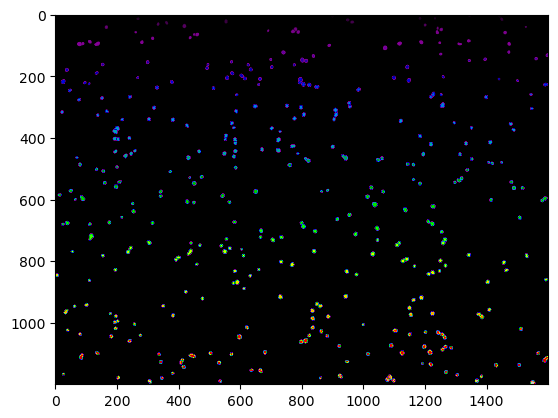

In [17]:
# result
print(count)
# plt.imshow(light_dilate, cmap='nipy_spectral')
plt.imshow(light_fil_cir, cmap='nipy_spectral')

In [17]:
# workflow for fluoroscence image
fluo_image = cv2.imread("./{}h/{}.TIF".format(3, 10), cv2.IMREAD_UNCHANGED)
fluo_binary = binary(fluo_image, threshold_value=4000, image_type='fluo')
otsu_threshold, otsu_binary = cv2.threshold(fluo_image, 0, np.iinfo(fluo_image.dtype).max, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [30]:
fluo_tophat = tophat(fluo_image, image_type='fluo', 
                    kernel_size=(7, 7), blur_size=(15, 15), standard_variance=0)

In [6]:
# display
cv2.imshow("Thresholded Blocks", fluo_binary)
cv2.waitKey()
cv2.destroyAllWindows()

In [23]:
light_image = cv2.imread("./{}h/{}.TIF".format(3, 9), cv2.IMREAD_UNCHANGED)
light_binary = tophat(light_image, image_type='light', kernel_size=(6, 6), blur_size=(11, 11), standard_variance=0)

light_cell_seg1 = segment_using_watershed(light_binary, min_distance=5)
_, light_fil_size = filter_by_size(light_cell_seg1, min_area=30, max_area=300)
light_dilate, light_close = closing(light_fil_size, 
                    dilate_iterations=3, dilate_kernel_size=(3, 3), dilate_kernel_type=cv2.MORPH_ELLIPSE,
                    erode_iterations=4, erode_kernel_size=(3, 3), erode_kernel_type=cv2.MORPH_ELLIPSE)

light_binary2 = (light_close>0)
light_cell_seg2 = segment_using_watershed(light_binary2, min_distance=5)
_, light_fil_size2 = filter_by_size(light_cell_seg2, min_area=30, max_area=300)
light_count, light_fil_cir = filter_by_circularity(light_fil_size2)

In [28]:
fluo_image = cv2.imread("./{}h/{}.TIF".format(3, 10), cv2.IMREAD_UNCHANGED)
fluo_binary = binary(fluo_image, threshold_value=4000, image_type='fluo')
# otsu_threshold, fluo_binary = cv2.threshold(fluo_image, 0, np.iinfo(fluo_image.dtype).max, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
fluo_cell_seg = segment_using_watershed(fluo_binary, min_distance=10)
fluo_num, fluo_fil_size = filter_by_size(fluo_cell_seg, min_area=20, max_area=200)

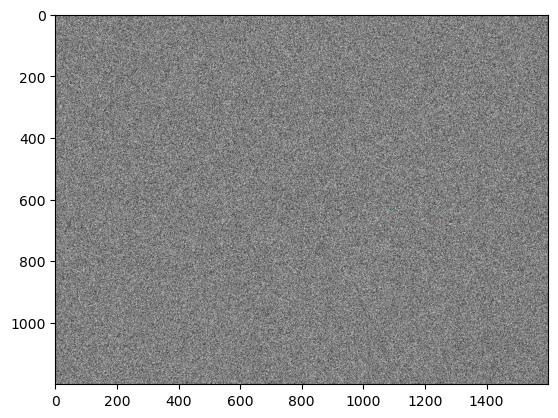

In [5]:
# print(light_cell_num)
plt.imshow(m_um_mask, cmap='nipy_spectral')

In [29]:
# Match the cells in both images
matched_cells, not_matched_cells = match_cells(light_fil_cir, fluo_fil_size, dis_thre=10)

print(f"Number of matched cells: {len(matched_cells)}")
print(f"Number of not matched cells: {len(not_matched_cells)}")

Number of matched cells: 317
Number of not matched cells: 62


In [ ]:
# display match
gray_image = cv2.imread("./{}h/{}.TIF".format(3, 9), cv2.IMREAD_UNCHANGED)
microscopy_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)

# print(microscopy_image.shape)

# Create a new image with the same size as the microscopy image
matched_mask_image = np.zeros(microscopy_image.shape, dtype=np.uint16)
not_matched_mask_image = np.zeros(microscopy_image.shape, dtype=np.uint16)

# Draw the matched cells on the result image
for micro_region, fluo_region in matched_cells:
    # Use the microscopy region's coordinates to create a mask for the cell
    cell_mask = (light_fil_cir == micro_region.label)

    # Set the color for the cell (e.g., red)
    match_cell_color = (0, 60000, 0)  # BGR format: (blue, green, red)

    # Draw the cell on the result image
    matched_mask_image[cell_mask] = match_cell_color

for fluo_region in not_matched_cells:
    cell_mask = (fluo_fil_size == fluo_region.label)

     # Set the color for the cell (e.g., red)
    not_match_cell_color = (0, 0, 60000)  # BGR format: (blue, green, red)

    # Draw the cell on the result image
    not_matched_mask_image[cell_mask] = not_match_cell_color

In [17]:
# Display the original microscopy image and the result image
# cv2.imshow("Original Image", gray_image)
cv2.imshow("Result Image1", m_um_mask)
# cv2.imshow("Result Image2", not_matched_mask_image)
cv2.waitKey()
cv2.destroyAllWindows()

In [33]:
# Load the 16-bit grayscale TIFF image and the RGB mask image
rgb_image = microscopy_image
mask1 = matched_mask_image
mask2 = not_matched_mask_image

# Set the transparency values (0 to 1) for the two masks
transparency1 = 0.3
transparency2 = 0.3

# Blend the first mask with the RGB image
result = cv2.addWeighted(rgb_image, 1-transparency1, mask1, transparency1, 0)

# Blend the second mask with the result
result = cv2.addWeighted(result, 1-transparency2, mask2, transparency2, 0)

# Save the resulting image
cv2.imwrite('result.tif', result)

# Display the resulting image
cv2.imshow('Result', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [19]:
tmp_result, tmp_result_trans, m_um_mask = plot_mask(microscopy_image=light_image, 
                    light_process=light_fil_cir, matched_cells=matched_cells,
                    fluo_process=fluo_fil_size, not_matched_cells=unmatched_cells)

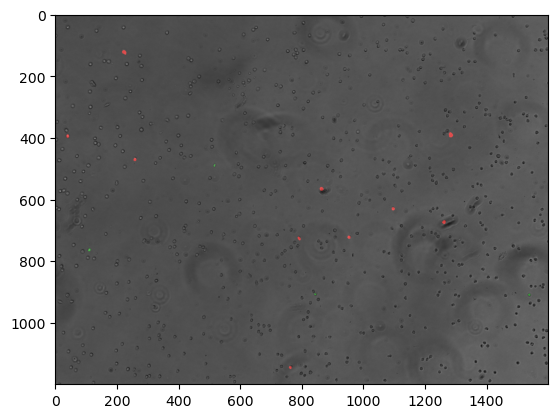

In [21]:
plt.imshow(m_um_mask)

In [7]:
m_um_mask

array([[[ 49,  49,  49],
        [197, 197, 197],
        [247, 247, 247],
        ...,
        [222, 222, 222],
        [  5,   5,   5],
        [ 80,  80,  80]],

       [[197, 197, 197],
        [ 22,  22,  22],
        [137, 137, 137],
        ...,
        [120, 120, 120],
        [250, 250, 250],
        [183, 183, 183]],

       [[ 12,  12,  12],
        [245, 245, 245],
        [220, 220, 220],
        ...,
        [112, 112, 112],
        [ 62,  62,  62],
        [172, 172, 172]],

       ...,

       [[ 52,  52,  52],
        [ 38,  38,  38],
        [  7,   7,   7],
        ...,
        [ 29,  29,  29],
        [ 92,  92,  92],
        [ 57,  57,  57]],

       [[ 78,  78,  78],
        [132, 132, 132],
        [153, 153, 153],
        ...,
        [167, 167, 167],
        [196, 196, 196],
        [107, 107, 107]],

       [[153, 153, 153],
        [ 33,  33,  33],
        [145, 145, 145],
        ...,
        [178, 178, 178],
        [ 92,  92,  92],
        [115, 115, 115]]

In [24]:
# workflow
fluo_threshold = {
                0: [4000, 4000, 4000, 4000, 4000, 4000], 
                1: [4000, 4000, 4000, 4000, 4000, 4000], 
                2: [4000, 4000, 4000, 4000, 4000, 4000], 
                3: [4000, 4000, 4000, 4000, 4000, 4000], 
                4: [4000, 4000, 4000, 4000, 4000, 4000], 
                5: [4000, 4000, 4000, 4000, 4000, 4000]
                 }

well = 0

death_rate_total = {}
death_rate_total['Time'] = ['0h', '1h', '2h', '3h', '4h', '5h']

for well in range(6):
    print(f"well:{well}")
    with open('./cell_count.txt', 'a') as file:
        # Write the text to the file
            file.write(f"well:{well}\n")

    death_rate_total[well] = []

    well_data = pd.DataFrame(columns=["time", "light_num", "fluo_num", "matched_num", "total_num", 'death_rate'])

    fig, axs = plt.subplots(6, 5, figsize=(10, 10))
    for ax in axs.flat:
        ax.axis('off')

    for time in range(6):
        light_num = 2 * well + 1
        fluo_num = 2 * well + 2
        # Preprocess and segment the microscopy image
        light_image = cv2.imread("./{}h/{}.TIF".format(time, light_num), cv2.IMREAD_UNCHANGED)
        light_binary = tophat(light_image, image_type='light', kernel_size=(6, 6), blur_size=(11, 11), standard_variance=0)

        light_cell_seg1 = segment_using_watershed(light_binary, min_distance=5)
        _, light_fil_size = filter_by_size(light_cell_seg1, min_area=30, max_area=300)
        light_dilate, light_close = closing(light_fil_size, 
                            dilate_iterations=3, dilate_kernel_size=(3, 3), dilate_kernel_type=cv2.MORPH_ELLIPSE,
                            erode_iterations=4, erode_kernel_size=(3, 3), erode_kernel_type=cv2.MORPH_ELLIPSE)
        
        light_binary2 = (light_close>0)
        light_cell_seg2 = segment_using_watershed(light_binary2, min_distance=5)
        _, light_fil_size2 = filter_by_size(light_cell_seg2, min_area=30, max_area=300)
        light_count, light_fil_cir = filter_by_circularity(light_fil_size2)


        # Preprocess and segment the microscopy image
        fluo_image = cv2.imread("./{}h/{}.TIF".format(time, fluo_num), cv2.IMREAD_UNCHANGED)
        fluo_binary = binary(fluo_image, threshold_value=fluo_threshold[time][well], image_type='fluo')
        # otsu_threshold, fluo_binary = cv2.threshold(fluo_image, 0, np.iinfo(fluo_image.dtype).max, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        fluo_cell_seg = segment_using_watershed(fluo_binary, min_distance=10)
        fluo_num, fluo_fil_size = filter_by_size(fluo_cell_seg, min_area=20, max_area=200)

        # Match the cells in both images
        matched_cells, unmatched_cells = match_cells(light_fil_cir, fluo_fil_size, dis_thre=10)

        # Plot the mask for matched and not_matched cells
        m_um_mask = plot_mask(microscopy_image=light_image, 
                            light_process=light_fil_cir, matched_cells=matched_cells,
                            fluo_process=fluo_fil_size, not_matched_cells=unmatched_cells)

        # Calculate the total_num and death_rate
        total_num = light_count + fluo_num - len(matched_cells)
        death_rate = fluo_num / total_num
        death_rate_total[well].append(death_rate)
        
        new_row = pd.DataFrame({'time': [time], 
                                "light_num": [light_count], 
                                "fluo_num": [fluo_num], 
                                "matched_num": [len(matched_cells)], 
                                "total_num": [total_num], 
                                'death_rate': [death_rate]})
        
        well_data = pd.concat([well_data, new_row])
        
        text = '\n'.join([f"time:{time}",
                          f"Total Number of cells: {total_num}",
                          f"Light_Num: {light_count}",
                          f"Death_Num: {fluo_num}",
                          f"Matched_Num: {len(matched_cells)}",
                          f"Death_rate: {death_rate}",
                          f"\n"])
        
        with open('./cell_count.txt', 'a') as file:
        # Write the text to the file
            file.write(text)
            

        axs[time, 0].imshow(light_image, cmap='gray', vmin=0, vmax=65535)
        axs[time, 0].set_title(f"{time}h-light")

        axs[time, 1].imshow(light_fil_cir, cmap='nipy_spectral')
        axs[time, 1].set_title(f"total_count:{total_num}")

        axs[time, 2].imshow(fluo_image, cmap='gray', vmin=0, vmax=65535)
        axs[time, 2].set_title(f"{time}h-fluo")

        axs[time, 3].imshow(fluo_fil_size, cmap='nipy_spectral')
        axs[time, 3].set_title(f"count:{fluo_num}")

        axs[time, 4].imshow(m_um_mask)
        axs[time, 4].set_title("mask_for_m/um_cells")

    death_rate_df = pd.DataFrame(death_rate_total)

    well_data.to_csv(f'./well{well}_output_data.csv', index=False)
    
    fig.suptitle(f'well{well}')
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'./well{well}_output_image.png', dpi=300)

well:0
well:1
well:2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


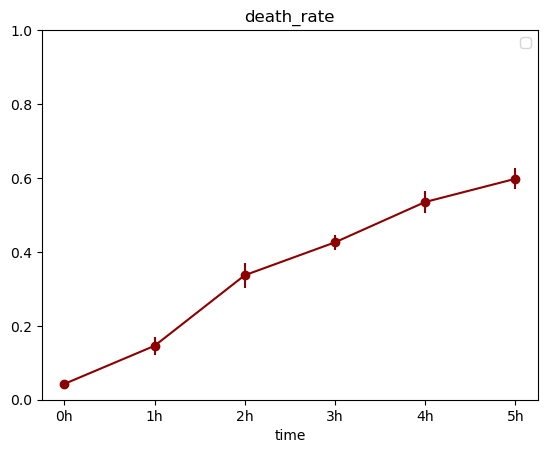

In [ ]:
try:
    death_rate_df = death_rate_df.set_index('Time')
except:
    pass

death_rate_df['death_rate_mean'] = death_rate_df.mean(axis=1)


# 计算每行数据的平均值和标准误差
mean_and_sem = death_rate_df.apply(lambda x: (np.mean(x), np.std(x)), axis=1)
result = pd.DataFrame(list(mean_and_sem), columns=['death_rate_mean', 'SEM'], index=death_rate_df.index)

# 绘制折线图
fig, ax = plt.subplots()
ax.errorbar(result.index.values, result['death_rate_mean'], yerr=result['SEM'], fmt='o-', color='darkred')
ax.set_xlabel('time')
ax.set_ylabel('')
ax.set_title('death_rate')
ax.legend()

ax.set_ylim([0, 1])

plt.savefig(f'./death_rate.png', dpi=300)